# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 32, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1
        'data_generation_filtering': False,
        'fixed_class_probability': True,
        'weighted_data_generation': False,
        
        'function_generation_type': 'distribtion',# 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 11111,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 11111,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 60,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets11111_var32_class2_distribtion_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets11111_var32_class2_distribtion_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [[None, None]]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [[None, None]]*number_of_trained_lambda_nets

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31
0,0.000,0.237,0.506,0.940,0.167,0.644,0.151,0.188,0.222,0.000,0.003,0.380,0.273,0.352,0.991,0.320,0.595,0.506,0.124,0.665,0.683,0.376,0.547,0.948,0.125,0.435,0.190,0.316,0.503,0.417,0.630,0.333
1,0.100,0.237,0.725,0.665,0.167,0.310,0.265,0.250,0.444,0.333,0.068,0.436,0.182,0.493,0.989,0.449,0.849,0.515,0.390,0.221,0.618,0.566,0.526,0.135,0.102,0.589,0.051,0.211,0.474,0.083,0.392,0.583
2,0.100,0.237,0.595,0.577,0.500,0.141,0.301,0.250,0.444,0.000,0.012,0.364,0.091,0.556,0.973,0.466,0.854,0.440,0.401,0.477,0.519,0.503,0.503,0.292,0.032,0.670,0.335,0.012,0.449,0.250,0.635,0.417
3,0.300,0.241,0.694,0.778,0.333,0.532,0.237,0.375,0.222,0.111,0.286,0.352,0.182,0.284,0.951,0.771,0.538,0.496,0.533,0.586,0.471,0.397,0.366,0.725,0.005,0.549,0.364,0.084,0.343,0.333,0.502,0.250
4,0.300,0.238,0.676,0.716,0.083,0.678,0.321,0.500,0.444,0.222,0.078,0.346,0.091,0.729,0.976,0.599,0.445,0.560,0.876,0.528,0.480,0.462,0.535,0.750,0.039,0.485,0.021,0.653,0.569,0.250,0.476,0.250
5,0.000,0.240,0.722,0.735,0.333,0.861,0.202,0.562,0.333,0.333,0.003,0.231,0.182,0.664,0.973,0.299,0.348,0.510,0.643,0.674,0.635,0.234,0.318,0.512,0.066,0.486,0.033,0.133,0.337,0.250,0.550,0.167
6,0.200,0.240,0.647,0.867,0.417,0.602,0.400,0.125,0.000,0.444,0.017,0.337,0.182,0.430,0.995,0.760,0.496,0.520,0.447,0.360,0.444,0.490,0.428,0.076,0.254,0.472,0.149,0.486,0.628,0.333,0.486,0.333
7,0.100,0.239,0.552,0.181,0.417,0.521,0.416,0.438,0.333,0.111,0.177,0.139,0.455,0.527,0.965,0.719,0.700,0.433,0.090,0.485,0.591,0.529,0.441,0.329,0.080,0.598,0.112,0.146,0.421,0.333,0.543,0.250
8,0.500,0.241,0.609,0.862,0.417,0.437,0.336,0.500,0.556,0.000,0.001,0.606,0.545,0.274,0.973,0.381,0.778,0.504,0.326,0.769,0.685,0.468,0.194,0.600,0.222,0.466,0.016,0.284,0.478,0.500,0.409,0.083
9,0.100,0.239,0.619,0.657,0.167,0.848,0.320,0.250,0.444,0.222,0.175,0.316,0.545,0.379,0.994,0.431,0.672,0.425,0.293,0.621,0.645,0.515,0.281,0.511,0.033,0.518,0.023,0.619,0.409,0.417,0.124,0.583


In [13]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


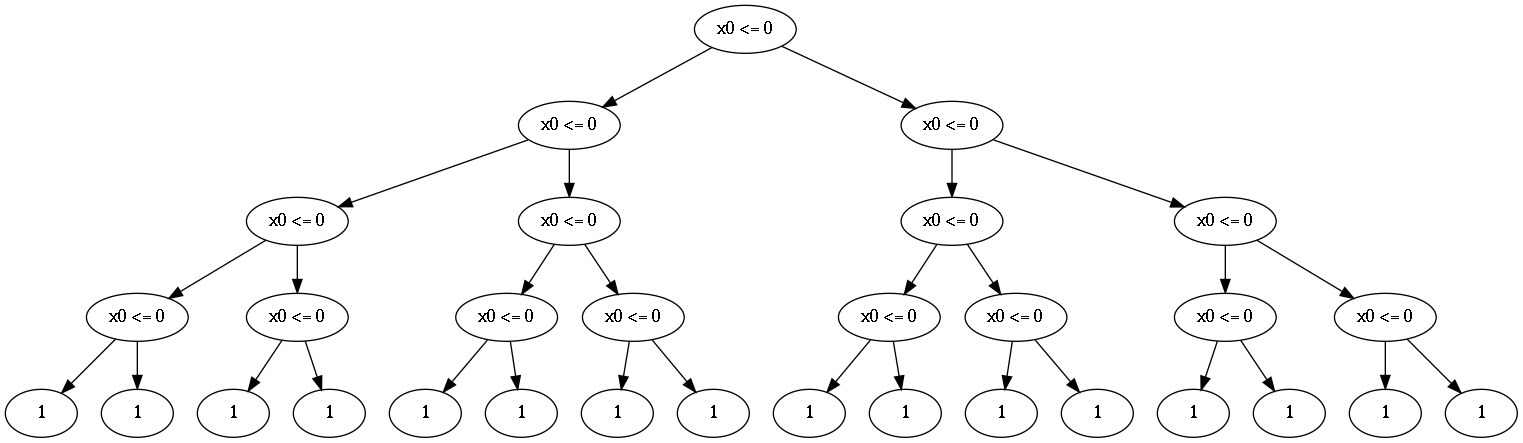

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [19]:
y_data_list[0][0]

feat0      0
feat1      0
feat2      0
feat3      0
feat4      0
feat5      0
feat6      0
feat7      0
feat8      0
feat9      0
feat10     0
feat11     0
feat12     0
feat13     0
feat14     0
split0     0
split1     0
split2     0
split3     0
split4     0
split5     0
split6     0
split7     0
split8     0
split9     0
split10    0
split11    0
split12    0
split13    0
split14    0
lp0        0
lp1        0
lp2        0
lp3        0
lp4        0
lp5        0
lp6        0
lp7        0
lp8        0
lp9        0
lp10       0
lp11       0
lp12       0
lp13       0
lp14       0
lp15       0
dtype: int64

In [20]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

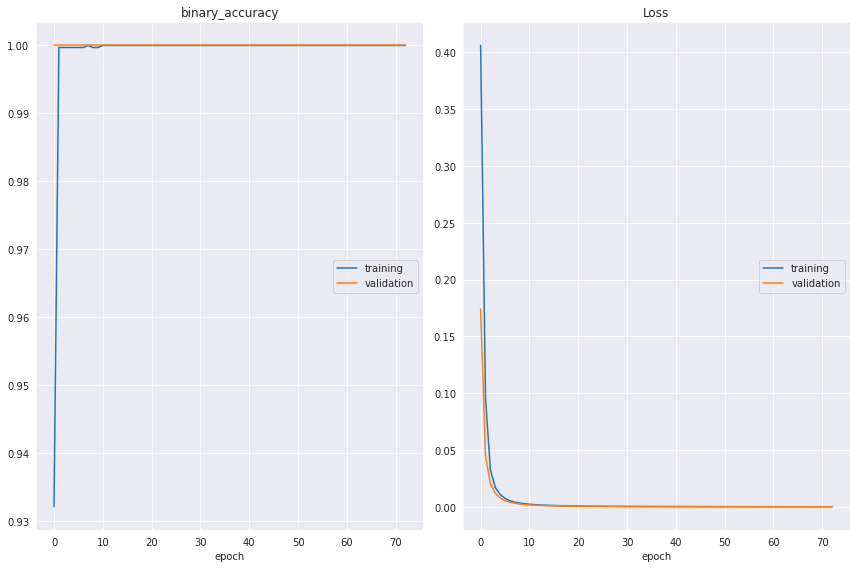

binary_accuracy
	training         	 (min:    0.932, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.406, cur:    0.000)
	validation       	 (min:    0.000, max:    0.174, cur:    0.000)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

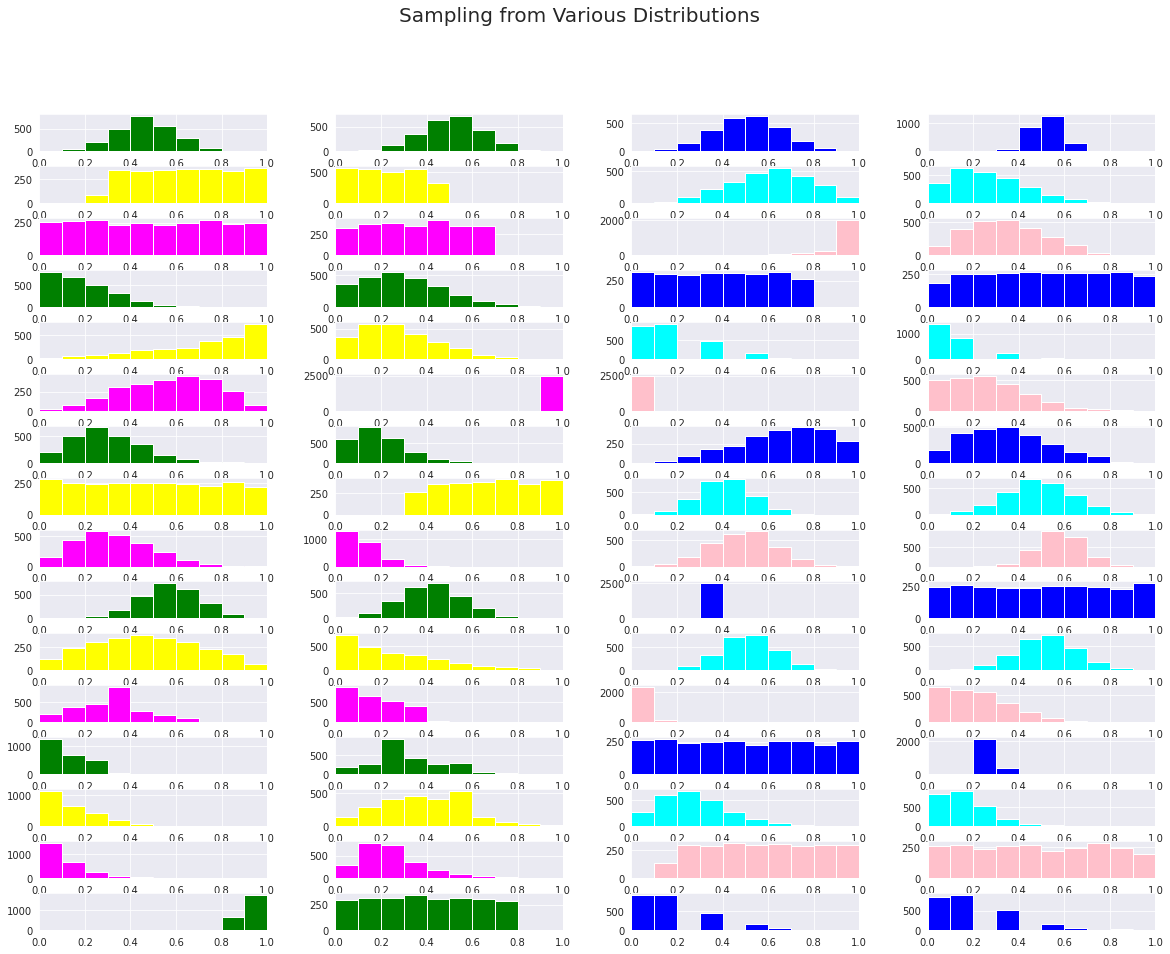

In [24]:
colors_list = ['green','blue','yellow','cyan','magenta','pink']

if config['data']['number_of_variables'] > 4:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
else:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

for axis_1 in ax:
    for axis_2 in axis_1:
        axis_2.set_xlim([0, 1])                          

plot_index = 0

for i in range(X_data_list[rand_index][1].values.shape[1]):
    colors = colors_list[i%6]

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()<=0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
    plot_index += 1

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()>0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
    plot_index += 1

fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()

In [25]:
distribution_parameter_list_list[0][1]

[{'poisson': {'class_0': {'lam': 1.9747500921550292},
   'class_1': {'lam': 2.404191826343525},
   'samples_class_0': 2500,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'uniform': {'class_0': {'low': 1.0130347681444523,
    'high': 1.0354655203048657},
   'class_1': {'low': 0.16193453025508675, 'high': 3.766808625548459},
   'samples_class_0': 2500,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'normal': {'class_0': {'loc': 3.0264761881276376,
    'scale': 0.42428188806225287},
   'class_1': {'loc': 1.5429785513215244, 'scale': 0.43420724632723784},
   'samples_class_0': 2500,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'beta': {'class_0': {'a': 1.6079093376622622, 'b': 1.2740140404130218},
   'class_1': {'a': 2.4473706994759263, 'b': 1.0049561833241072},
   'samples_class_0': 2500,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'poisson': {'class_0': {'lam': 4.051666171909894},
   'class_1': {'lam': 1.2717924366845672},
   'samples_class_0': 2

In [26]:
#%load_ext autoreload
#%autoreload 2

In [27]:
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:   35.3s
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=60)]: Done 392 tasks      | elapsed:  1.8min
[Parallel(n_jobs=60)]: Done 680 tasks      | elapsed:  2.8min
[Parallel(n_jobs=60)]: Done 1032 tasks      | elapsed:  3.8min
[Parallel(n_jobs=60)]: Done 1448 tasks      | elapsed:  5.1min
[Parallel(n_jobs=60)]: Done 1928 tasks      | elapsed:  6.5min
[Parallel(n_jobs=60)]: Done 2472 tasks      | elapsed:  8.2min
[Parallel(n_jobs=60)]: Done 3080 tasks      | elapsed:  9.9min
[Parallel(n_jobs=60)]: Done 3752 tasks      | elapsed: 11.9min
[Parallel(n_jobs=60)]: Done 4488 tasks      | elapsed: 14.1min
[Parallel(n_jobs=60)]: Done 5288 tasks      | elapsed: 16.4min
[Parallel(n_jobs=60)]: Done 6152 tasks      | elapsed: 18.9min
[Parallel(n_jobs=60)]: Done 7080 tasks      | elapsed: 21.7min
[Parallel(n_jobs=60)]: Done 8072 tasks      |

In [28]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 32),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 32),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [29]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [30]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [32]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_156,loss_epoch_157,loss_epoch_158,loss_epoch_159,loss_epoch_160,loss_epoch_161,loss_epoch_162,loss_epoch_163,loss_epoch_164,loss_epoch_165,loss_epoch_166,loss_epoch_167,loss_epoch_168,loss_epoch_169,loss_epoch_170,loss_epoch_171,loss_epoch_172,loss_epoch_173,loss_epoch_174,loss_epoch_175,loss_epoch_176,loss_epoch_177,loss_epoch_178,loss_epoch_179,loss_epoch_180,loss_epoch_181,loss_epoch_182,loss_epoch_183,loss_epoch_184,loss_epoch_185,loss_epoch_186,loss_epoch_187,loss_epoch_188,loss_epoch_189,loss_epoch_190,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200,loss_epoch_201,loss_epoch_202,loss_epoch_203,loss_epoch_204,loss_epoch_205,loss_epoch_206,loss_epoch_207,loss_epoch_208,loss_epoch_209,loss_epoch_210,loss_epoch_211,loss_epoch_212,loss_epoch_213,loss_epoch_214,loss_epoch_215,loss_epoch_216,loss_epoch_217,loss_epoch_218,loss_epoch_219,loss_epoch_220,loss_epoch_221,loss_epoch_222,loss_epoch_223,loss_epoch_224,loss_epoch_225,loss_epoch_226,loss_epoch_227,loss_epoch_228,loss_epoch_229,loss_epoch_230,loss_epoch_231,loss_epoch_232,loss_epoch_233,loss_epoch_234,loss_epoch_235,loss_epoch_236,loss_epoch_237,loss_epoch_238,loss_epoch_239,loss_epoch_240,loss_epoch_241,loss_epoch_242,loss_epoch_243,loss_epoch_244,loss_epoch_245,loss_epoch_246,loss_epoch_247,loss_epoch_248,loss_epoch_249,loss_epoch_250,loss_epoch_251,loss_epoch_252,loss_epoch_253,loss_epoch_254,loss_epoch_255
count,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11098.000,11029.000,10920.000,10752.000,10735.000,10577.000,9183.000,7557.000,5952.000,5189.000,4760.000,4550.000,4395.000,4175.000,3769.000,3377.000,3056.000,2835.000,2667.000,2512.000,2378.000,2247.000,2112.000,1993.000,1881.000,1776.000,1665.000,1580.000,1492.000,1405.000,1324.000,1226.000,1158.000,1069.000,1004.000,931.000,862.000,810.000,761.000,703.000,665.000,620.000,572.000,...,6.000,5.000,5.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,3.000,3.000,3.0

In [33]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_156,val_loss_epoch_157,val_loss_epoch_158,val_loss_epoch_159,val_loss_epoch_160,val_loss_epoch_161,val_loss_epoch_162,val_loss_epoch_163,val_loss_epoch_164,val_loss_epoch_165,val_loss_epoch_166,val_loss_epoch_167,val_loss_epoch_168,val_loss_epoch_169,val_loss_epoch_170,val_loss_epoch_171,val_loss_epoch_172,val_loss_epoch_173,val_loss_epoch_174,val_loss_epoch_175,val_loss_epoch_176,val_loss_epoch_177,val_loss_epoch_178,val_loss_epoch_179,val_loss_epoch_180,val_loss_epoch_181,val_loss_epoch_182,val_loss_epoch_183,val_loss_epoch_184,val_loss_epoch_185,val_loss_epoch_186,val_loss_epoch_187,val_loss_epoch_188,val_loss_epoch_189,val_loss_epoch_190,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200,val_loss_epoch_201,val_loss_epoch_202,val_loss_epoch_203,val_loss_epoch_204,val_loss_epoch_205,val_loss_epoch_206,val_loss_epoch_207,val_loss_epoch_208,val_loss_epoch_209,val_loss_epoch_210,val_loss_epoch_211,val_loss_epoch_212,val_loss_epoch_213,val_loss_epoch_214,val_loss_epoch_215,val_loss_epoch_216,val_loss_epoch_217,val_loss_epoch_218,val_loss_epoch_219,val_loss_epoch_220,val_loss_epoch_221,val_loss_epoch_222,val_loss_epoch_223,val_loss_epoch_224,val_loss_epoch_225,val_loss_epoch_226,val_loss_epoch_227,val_loss_epoch_228,val_loss_epoch_229,val_loss_epoch_230,val_loss_epoch_231,val_loss_epoch_232,val_loss_epoch_233,val_loss_epoch_234,val_loss_epoch_235,val_loss_epoch_236,val_loss_epoch_237,val_loss_epoch_238,val_loss_epoch_239,val_loss_epoch_240,val_loss_epoch_241,val_loss_epoch_242,val_loss_epoch_243,val_loss_epoch_244,val_loss_epoch_245,val_loss_epoch_246,val_loss_epoch_247,val_loss_epoch_248,val_loss_epoch_249,val_loss_epoch_250,val_loss_epoch_251,val_loss_epoch_252,val_loss_epoch_253,val_loss_epoch_254,val_loss_epoch_255
count,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,11111.000,

In [34]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_156,binary_accuracy_epoch_157,binary_accuracy_epoch_158,binary_accuracy_epoch_159,binary_accuracy_epoch_160,binary_accuracy_epoch_161,binary_accuracy_epoch_162,binary_accuracy_epoch_163,binary_accuracy_epoch_164,binary_accuracy_epoch_165,binary_accuracy_epoch_166,binary_accuracy_epoch_167,binary_accuracy_epoch_168,binary_accuracy_epoch_169,binary_accuracy_epoch_170,binary_accuracy_epoch_171,binary_accuracy_epoch_172,binary_accuracy_epoch_173,binary_accuracy_epoch_174,binary_accuracy_epoch_175,binary_accuracy_epoch_176,binary_accuracy_epoch_177,binary_accuracy_epoch_178,binary_accuracy_epoch_179,binary_accuracy_epoch_180,binary_accuracy_epoch_181,binary_accuracy_epoch_182,binary_accuracy_epoch_183,binary_accuracy_epoch_184,binary_accuracy_epoch_185,binary_accuracy_epoch_186,binary_accuracy_epoch_187,binary_accuracy_epoch_188,binary_accuracy_epoch_189,binary_accuracy_epoch_190,binary_accuracy_epoch_191,binary_accuracy_epoch_192,binary_accuracy_epoch_193,binary_accuracy_epoch_194,binary_accuracy_epoch_195,binary_accuracy_epoch_196,binary_accuracy_epoch_197,binary_accuracy_epoch_198,binary_accuracy_epoch_199,binary_accuracy_epoch_200,binary_accuracy_epoch_201,binary_accuracy_epoch_202,binary_accuracy_epoch_203,binary_accuracy_epoch_204,binary_accuracy_epoch_205,binary_accuracy_epoch_206,binary_accuracy_epoch_207,binary_accuracy_epoch_208,binary_accuracy_epoch_209,binary_accuracy_epoch_210,binary_accuracy_epoch_211,binary_accuracy_epoch_212,binary_accuracy_epoch_213,binary_accuracy

In [35]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_156,val_binary_accuracy_epoch_157,val_binary_accuracy_epoch_158,val_binary_accuracy_epoch_159,val_binary_accuracy_epoch_160,val_binary_accuracy_epoch_161,val_binary_accuracy_epoch_162,val_binary_accuracy_epoch_163,val_binary_accuracy_epoch_164,val_binary_accuracy_epoch_165,val_binary_accuracy_epoch_166,val_binary_accuracy_epoch_167,val_binary_accuracy_epoch_168,val_binary_accuracy_epoch_169,val_binary_accuracy_epoch_170,val_binary_accuracy_epoch_171,val_binary_accuracy_epoch_172,val_binary_accuracy_epoch_173,val_binary_accuracy_epoch_174,val_binary_accuracy_epoch_175,val_binary_accuracy_epoch_176,val_binary_accuracy_epoch_177,val_binary_accuracy_epoch_178,val_binary_accuracy_epoch_179,val_binary_accuracy_epoch_180,val_binary_accuracy_epoch_181,val_binary_accuracy_epoch_182,val_binary_accuracy_epoch_183,val_binary_accuracy_epoch_184,val_binary_accuracy_epoch_185,val_binary_accuracy_epoch_186,val_binary_accuracy_epoch_187,val_binary_accuracy_epoch_188,val_binary_accuracy_epoch_189,val_binary_accuracy_epoch_190,val_binary_accuracy_epoch_191,val_binary_accuracy_epoch_192,val_binary_accura

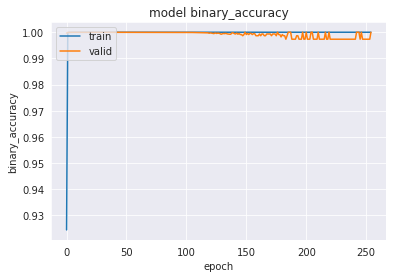

In [36]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


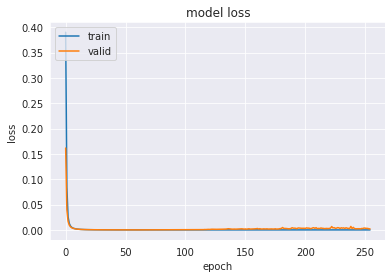

In [37]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [38]:
X_data_list[-10][1]

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31
0,0.122,0.671,0.450,0.015,0.386,0.670,0.235,0.675,0.778,0.500,0.752,0.008,0.013,0.011,0.000,0.154,0.813,0.181,0.449,0.538,0.120,0.228,0.428,0.073,0.449,0.525,0.792,0.017,0.691,0.617,0.087,0.000
1,0.164,0.935,0.209,0.573,0.173,0.695,0.279,0.095,0.868,0.429,0.793,0.016,0.750,0.021,0.000,0.077,0.680,0.152,0.375,0.598,0.153,0.106,0.429,0.081,0.248,0.507,0.141,0.010,0.456,0.515,0.003,0.003
2,0.081,0.860,0.336,0.152,0.693,0.688,0.259,0.216,0.910,0.857,0.969,0.075,0.177,0.067,0.008,0.154,0.581,0.249,0.349,0.542,0.091,0.108,0.429,0.040,0.351,0.578,0.025,0.015,0.307,0.459,0.189,0.000
3,0.094,0.216,0.512,0.673,0.745,0.713,0.112,0.348,0.492,0.214,0.819,0.052,0.563,0.019,0.081,0.077,0.593,0.231,0.586,0.694,0.132,0.432,0.432,0.088,0.519,0.732,0.080,0.128,0.768,0.331,0.225,0.000
4,0.163,0.413,0.344,0.028,0.461,0.681,0.300,0.147,0.829,0.286,0.631,0.052,0.268,0.015,0.023,0.462,0.752,0.019,0.340,0.674,0.050,0.169,0.423,0.052,0.406,0.644,0.255,0.151,0.532,0.743,0.185,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.096,0.514,0.718,0.282,0.278,0.283,0.252,0.587,0.285,0.357,0.008,0.998,0.402,0.240,0.604,0.077,0.980,0.860,0.615,0.579,0.145,0.377,0.440,0.242,0.834,0.997,0.315,0.215,0.430,0.731,0.926,0.185
4996,0.204,0.340,0.496,0.481,0.302,0.358,0.263,0.265,0.397,0.143,0.019,0.998,0.579,0.081,0.921,0.462,0.983,0.931,0.522,0.438,0.380,0.243,0.208,0.426,0.788,0.908,0.189,0.134,0.231,0.589,0.404,0.086
4997,0.006,0.658,0.728,0.448,0.287,0.729,0.326,0.931,0.677,0.071,0.005,0.993,0.384,0.097,0.674,0.462,0.880,0.927,0.554,0.470,0.442,0.266,0.532,0.186,0.805,0.965,0.413,0.156,0.707,0.762,0.663,0.141
4998,0.175,0.946,0.540,0.551,0.273,0.664,0.153,0.998,0.351,0.214,0.024,0.995,0.398,0.158,0.889,0.077,0.996,0.977,0.698,0.474,0.250,0.195,0.769,0.297,0.786,0.940,0.405,0.359,0.682,0.870,0.382,0.064
